In [8]:
# Import all required libraries
import pandas as pd
import numpy as np
import pingouin as pg
from pathlib import Path
from scipy import stats
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import seaborn as sns
import os.path as op
import re
import nibabel as nib

# Additional imports for neuroimaging and atlas processing
from nilearn import datasets, masking, input_data, plotting
from nilearn.maskers import NiftiMapsMasker
from nilearn.connectome import ConnectivityMeasure
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [9]:
# Setup directories and plotting theme
RELI_DIR = Path("dset/derivatives/caps/interrater")
FIGURES_DIR = Path("dset/derivatives/figures")
# will use loop later to run over all subjects
OUT_DIR = Path("dset/derivatives/caps")


In [10]:
# Define all runs for each participant and episode
participant_data = {
    "sub-Blossom": {
        "S01E01": [1, 2, 3],           # Episode 1 has 3 runs
        "S01E02": [1, 2, 3, 4, 5, 6, 7], # Episode 2 has 7 runs 
    # Add other participants as needed
} }

In [11]:
# Define CAP masks to process
cap_masks = []
for cap_num in range(1, 5):  # CAPs 1-4
    for polarity in ['pos', 'neg']:
        mask_path = Path(f"dset/derivatives/caps/spatial_masks/sub-Blossom_zscore-weighted-0_CAP_{cap_num}_{polarity}.nii.gz")
        if mask_path.exists():
            cap_masks.append({
                'cap_num': cap_num,
                'polarity': polarity,
                'path': mask_path,
                'name': f"CAP{cap_num}_{polarity}"
            })

print(f"Found {len(cap_masks)} CAP masks to process:")
for mask_info in cap_masks:
    print(f"  - {mask_info['name']}: {mask_info['path']}")

removed_clips_df = pd.read_csv(Path("dset/derivatives/annotations/removed_clips_log.csv"))

# Process each CAP mask
for mask_info in cap_masks:
    print(f"\n{'='*80}")
    print(f"PROCESSING {mask_info['name'].upper()}")
    print(f"{'='*80}")
    
    # Load the weighted mask
    print(f"Loading weighted mask: {mask_info['path']}")
    mask_img = nib.load(mask_info['path'])
    mask_data = mask_img.get_fdata()

    caps_masker = NiftiMapsMasker(
        maps_img=mask_img,
        standardize=True,
        memory='nilearn_cache',
        mask_type="whole-brain",
        verbose=1
    )

    # Initialize storage for participant-level matrices for this CAP
    all_participant_matrices = {}

    # Process each episode
    for sub_id, episodes in participant_data.items():
        print(f"\n{'='*60}")
        print(f"PROCESSING {sub_id} - {mask_info['name']}")
        print(f"{'='*60}")
        
        for episode_key, run_numbers in episodes.items():
            # Handle both episode naming conventions
            if episode_key.startswith('S01E'):
                ep_num = int(episode_key[-2:])  # Extract from S01E02
            else:
                ep_num = int(episode_key.split('_')[1])  # Extract from episode_2
            
            print(f"\n{'='*50}")
            print(f"Processing Episode {ep_num} with {len(run_numbers)} runs...")
            print(f"{'='*50}")
            
            # Get excluded clips for this episode
            excluded_clips_episode = removed_clips_df[removed_clips_df['episode'] == episode_key]['episode_position'].tolist()
            print(f"Found {len(excluded_clips_episode)} excluded clips for {episode_key}: {excluded_clips_episode[:10] if len(excluded_clips_episode) > 10 else excluded_clips_episode}...")
            
            participant_timeseries = []
            all_clip_positions = []  # Track which episode position each TR corresponds to
            
            for run_num in run_numbers:
                print(f"  Processing run {run_num}...")
                
                TASK_DIR = Path(f"dset/{sub_id}/ses-{ep_num:02d}/func") 
                
                # Construct the filename - note that run number is NOT zero-padded
                task_filename = f"{sub_id}_ses-{ep_num:02d}_task-strangerthings_run-{run_num}_part-mag_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz"
                task_filepath = TASK_DIR / task_filename

                # Extract time series
                print(f"    Extracting time series from {task_filepath.name}...")
                time_series = caps_masker.fit_transform(task_filepath)
                    
                print(f"    Original time series shape: {time_series.shape} (TRs x ROIs)")
                
                # Remove first 5 TRs for T1 equilibration
                if time_series.shape[0] > 5:
                    time_series_trimmed = time_series[5:]  # Remove first 6 TRs
                    print(f"    After removing first 5 TRs: {time_series_trimmed.shape} (TRs x ROIs)")
                else:
                    print(f"    WARNING: Run has only {time_series.shape[0]} TRs, cannot remove 5 TRs!")
                    time_series_trimmed = time_series  # Keep all TRs if less than 6
                
                # Track episode positions for each TR (after removing first 5)
                # The first 5 TRs had no stimulus, so TR 6 = clip0000, TR 7 = clip0001, etc.
                # Calculate the starting clip position for this run in the episode sequence
                if run_num == 1:
                    run_start_clip = 1  # First clip of episode
                else:
                    # Calculate based on previous runs' clip counts
                    run_start_clip = len(all_clip_positions) + 1
                
                # Map each remaining TR to its corresponding clip position
                tr_positions = list(range(run_start_clip, run_start_clip + time_series_trimmed.shape[0]))
                all_clip_positions.extend(tr_positions)
                    
                # Store z-scored time series for this run (after TR removal)
                participant_timeseries.append(time_series_trimmed)

            if participant_timeseries:
                # Concatenate all runs for this episode
                print(f"\nConcatenating {len(participant_timeseries)} runs for {sub_id} Episode {ep_num}...")
                participant_matrix = np.vstack(participant_timeseries)
                
                print(f"Original participant matrix shape: {participant_matrix.shape}")
                print(f"  - Total TRs across all runs: {participant_matrix.shape[0]}")
                print(f"  - Episode positions tracked: {len(all_clip_positions)}")
                
                # Create mask to exclude clips
                exclude_mask = np.array([pos in excluded_clips_episode for pos in all_clip_positions])
                keep_mask = ~exclude_mask
                
                excluded_count = np.sum(exclude_mask)
                print(f"  - Excluding {excluded_count} TRs based on removed clips")
                
                # Filter the participant matrix
                if np.any(keep_mask):
                    participant_matrix_filtered = participant_matrix[keep_mask]
                    print(f"Filtered participant matrix shape: {participant_matrix_filtered.shape}")
                else:
                    print("Warning: All TRs would be excluded! Using original matrix.")
                    participant_matrix_filtered = participant_matrix
                
                # Store the participant-level matrix
                episode_key_safe = f"{sub_id}_ep{ep_num}"
                all_participant_matrices[episode_key_safe] = participant_matrix_filtered
                
                # Save the participant matrix
                output_dir = OUT_DIR / "weighted_timeseries"
                output_dir.mkdir(parents=True, exist_ok=True)
                
                # Save as CSV for easier inspection
                output_csv = output_dir / f"{sub_id}_ep{ep_num}_{mask_info['name']}_weighted_timeseries.csv"
                df_matrix = pd.DataFrame(participant_matrix_filtered, 
                                        columns=[f"{mask_info['name']}_weighted"])
                df_matrix.to_csv(output_csv, index=False)
                print(f"Saved participant matrix (CSV) to: {output_csv}")
                
                # Save exclusion info
                exclusion_info = {
                    'episode': episode_key,
                    'cap_mask': mask_info['name'],
                    'original_trs_before_trimming': int(participant_matrix.shape[0]) + (len(run_numbers) * 5),  # Add back removed TRs
                    'trs_removed_for_t1_equilibration': len(run_numbers) * 5,  # 5 TRs per run
                    'original_trs_after_trimming': int(participant_matrix.shape[0]),
                    'excluded_trs': int(excluded_count),
                    'final_trs': int(participant_matrix_filtered.shape[0]),
                    'excluded_positions': [float(pos) for pos in excluded_clips_episode],
                    'excluded_tr_indices': [int(idx) for idx in np.where(exclude_mask)[0].tolist()]
                }
                
                exclusion_file = output_dir / f"{sub_id}_ep{ep_num}_{mask_info['name']}_exclusion_info.json"
                import json
                with open(exclusion_file, 'w') as f:
                    json.dump(exclusion_info, f, indent=2)
                print(f"Saved exclusion info to: {exclusion_file}")

    print(f"\n{'='*60}")
    print(f"PROCESSING COMPLETE FOR {mask_info['name']}")
    print(f"{'='*60}")
    print(f"Processed {len(all_participant_matrices)} participant-episode combinations:")
    for key, matrix in all_participant_matrices.items():
        print(f"  {key}: {matrix.shape[0]} TRs × {matrix.shape[1]} ROIs (after exclusions)")

print(f"\n{'='*80}")
print("ALL CAP PROCESSING COMPLETE")
print(f"{'='*80}")

Found 6 CAP masks to process:
  - CAP1_pos: dset/derivatives/caps/spatial_masks/sub-Blossom_zscore-weighted-0_CAP_1_pos.nii.gz
  - CAP1_neg: dset/derivatives/caps/spatial_masks/sub-Blossom_zscore-weighted-0_CAP_1_neg.nii.gz
  - CAP2_pos: dset/derivatives/caps/spatial_masks/sub-Blossom_zscore-weighted-0_CAP_2_pos.nii.gz
  - CAP2_neg: dset/derivatives/caps/spatial_masks/sub-Blossom_zscore-weighted-0_CAP_2_neg.nii.gz
  - CAP3_pos: dset/derivatives/caps/spatial_masks/sub-Blossom_zscore-weighted-0_CAP_3_pos.nii.gz
  - CAP3_neg: dset/derivatives/caps/spatial_masks/sub-Blossom_zscore-weighted-0_CAP_3_neg.nii.gz

PROCESSING CAP1_POS
Loading weighted mask: dset/derivatives/caps/spatial_masks/sub-Blossom_zscore-weighted-0_CAP_1_pos.nii.gz

PROCESSING sub-Blossom - CAP1_pos

Processing Episode 1 with 3 runs...
Found 84 excluded clips for S01E01: [30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 41.0]...
  Processing run 1...
    Extracting time series from sub-Blossom_ses-01_task-strangerthi

/Users/chloehampson/Desktop/diva-emotion-dfc/.venv/lib/python3.14/site-packages/sklearn/utils/_set_output.py:316: UserWarning: memory_level is currently set to 0 but a Memory object has been provided. Setting memory_level to 1.
  data_to_wrap = f(self, X, *args, **kwargs)


[NiftiMapsMasker.wrapped] Finished fit
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker.filter_and_extract...
filter_and_extract(PosixPath('dset/sub-Blossom/ses-01/func/sub-Blossom_ses-01_task-strangerthings_run-1_part-mag_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz'), 
<nilearn.maskers.nifti_maps_masker._ExtractionFunctor object at 0x118d37610>, { 'allow_overlap': True,
  'clean_args': None,
  'clean_kwargs': {},
  'cmap': 'CMRmap_r',
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'keep_masked_maps': True,
  'low_pass': None,
  'maps_img': <nibabel.nifti1.Nifti1Image object at 0x1162ce8a0>,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, sample_mask=None, dtype=None, memory=Memory(location=nilearn

/Users/chloehampson/Desktop/diva-emotion-dfc/.venv/lib/python3.14/site-packages/sklearn/utils/_set_output.py:316: UserWarning: memory_level is currently set to 0 but a Memory object has been provided. Setting memory_level to 1.
  data_to_wrap = f(self, X, *args, **kwargs)


[NiftiMapsMasker.wrapped] Finished fit
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker.filter_and_extract...
filter_and_extract(PosixPath('dset/sub-Blossom/ses-01/func/sub-Blossom_ses-01_task-strangerthings_run-1_part-mag_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz'), 
<nilearn.maskers.nifti_maps_masker._ExtractionFunctor object at 0x119933c50>, { 'allow_overlap': True,
  'clean_args': None,
  'clean_kwargs': {},
  'cmap': 'CMRmap_r',
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'keep_masked_maps': True,
  'low_pass': None,
  'maps_img': <nibabel.nifti1.Nifti1Image object at 0x119d79e20>,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, sample_mask=None, dtype=None, memory=Memory(location=nilearn

KeyboardInterrupt: 


PLOTTING sub-Blossom
📁 Figure saved: dset/derivatives/figures/sub-Blossom_ep2_CAP1_emotion_correlation.png
📁 Figure saved: dset/derivatives/figures/sub-Blossom_ep2_CAP1_emotion_correlation.png


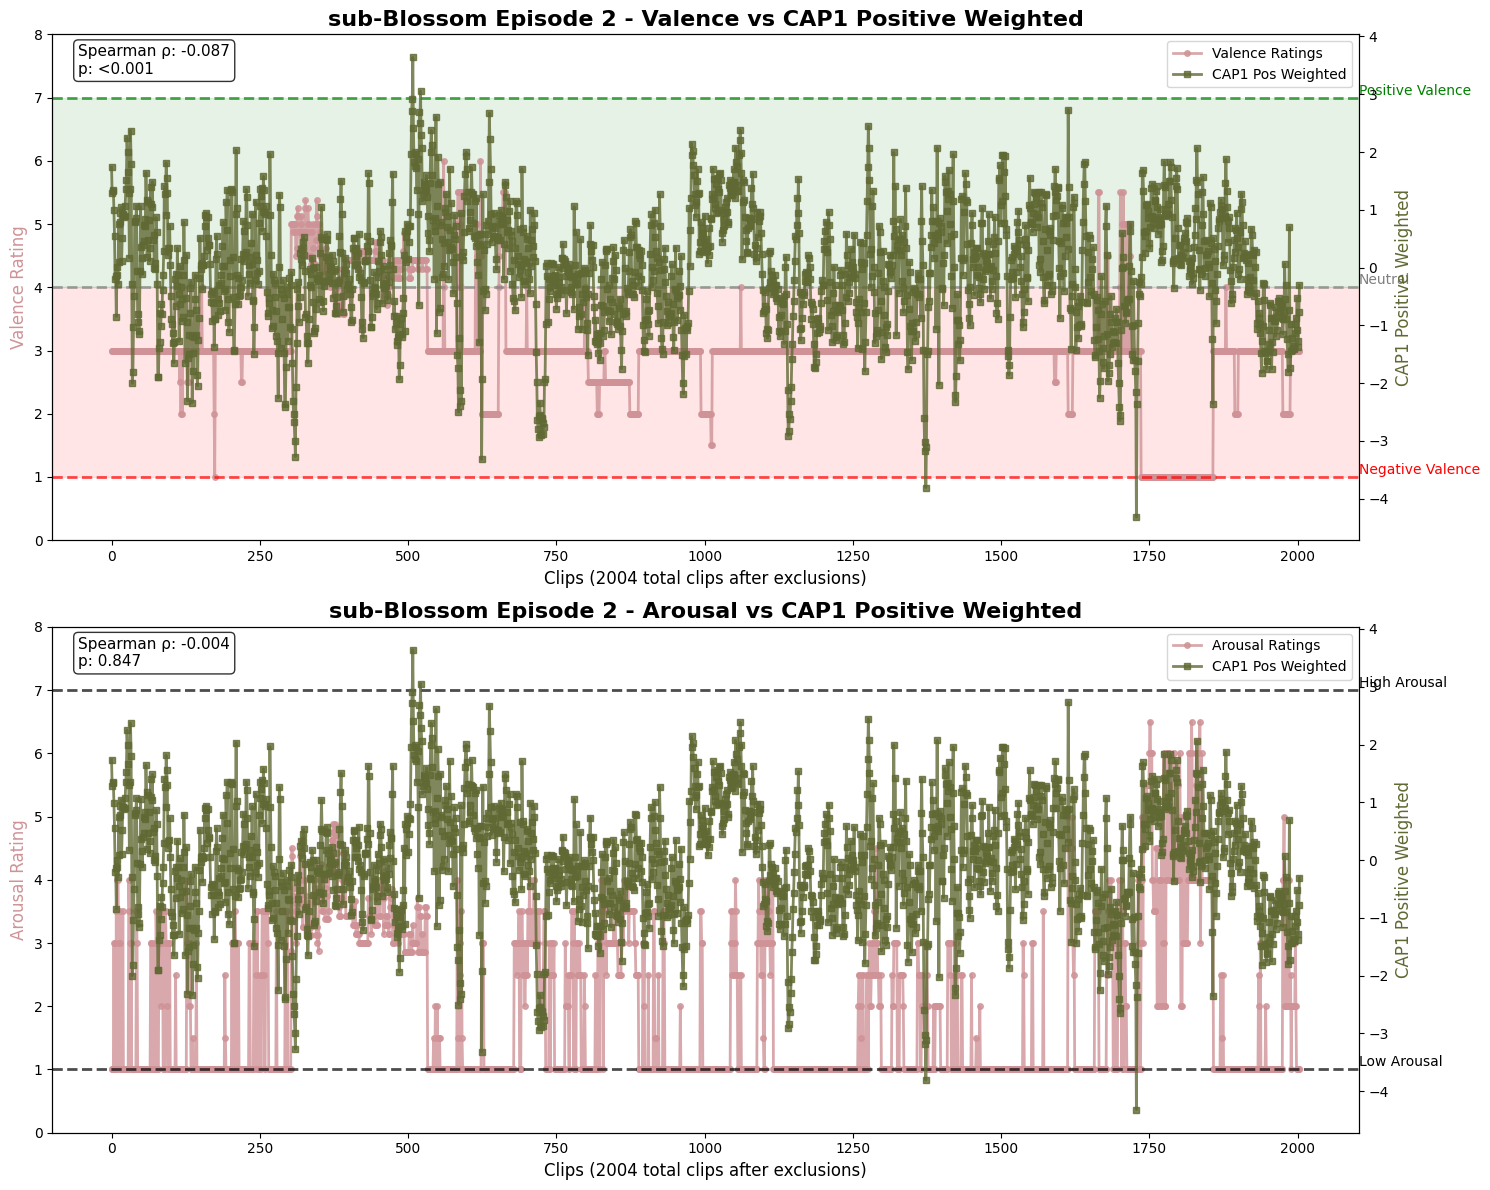

Data lengths: CAP=2004, Valence=2004, Arousal=2004
Correlations: Valence r=-0.087 (p=0.000), Arousal r=-0.004 (p=0.847)

PLOTTING COMPLETE


In [ ]:
# Plot CAP weighted timeseries with emotion ratings for all episodes and all CAPs
cap_names = []
for cap_num in range(1, 5):  # CAPs 1-4
    for polarity in ['pos', 'neg']:
        cap_name = f"CAP{cap_num}_{polarity}"
        # Check if the corresponding CSV file exists
        test_path = OUT_DIR / "weighted_timeseries" / f"sub-Blossom_ep1_{cap_name}_weighted_timeseries.csv"
        if test_path.exists() or Path(f"dset/derivatives/caps/spatial_masks/sub-Blossom_zscore-weighted-0_CAP_{cap_num}_{polarity}.nii.gz").exists():
            cap_names.append(cap_name)

print(f"Found CAPs to plot: {cap_names}")

for cap_name in cap_names:
    print(f"\n{'='*80}")
    print(f"PLOTTING {cap_name.upper()}")
    print(f"{'='*80}")
    
    for sub_id, episodes in participant_data.items():
        print(f"\n{'='*60}")
        print(f"PLOTTING {sub_id} - {cap_name}")
        print(f"{'='*60}")

        for episode_key, run_numbers in episodes.items():
            # Handle both episode naming conventions
            if episode_key.startswith('S01E'):
                ep_num = int(episode_key[-2:])  # Extract from S01E02
            else:
                ep_num = int(episode_key.split('_')[1])  # Extract from episode_2
            
            print(f"\n{'='*50}")
            print(f"Plotting Episode {ep_num} - {cap_name}")
            print(f"{'='*50}")

            # Load data
            bold_csv_path = OUT_DIR / "weighted_timeseries" / f"{sub_id}_ep{ep_num}_{cap_name}_weighted_timeseries.csv"
            emotion_csv_path = RELI_DIR / f"S01E{ep_num:02d}_avg.csv"
            
            if not bold_csv_path.exists():
                print(f"Warning: BOLD data not found at {bold_csv_path}")
                continue
                
            if not emotion_csv_path.exists():
                print(f"Warning: Emotion data not found at {emotion_csv_path}")
                continue
            
            bold_df = pd.read_csv(bold_csv_path)
            emotion_df = pd.read_csv(emotion_csv_path)

            # Extract relevant columns
            cap_col_name = f"{cap_name}_weighted"
            cap = bold_df[cap_col_name]
            valence = emotion_df['valence']
            arousal = emotion_df['arousal']
            
            # Ensure same length
            min_length = min(len(cap), len(valence), len(arousal))
            cap = cap[:min_length]
            valence = valence[:min_length]
            arousal = arousal[:min_length]
            
            # Calculate correlations for display
            val_corr, val_p = spearmanr(cap, valence)
            aro_corr, aro_p = spearmanr(cap, arousal)

            # Create the plot
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
            
            # Define colors
            colors = ['#CF9397', "#606933", '#E5D28E']
            
            # Valence plot
            ax1.axhspan(1, 4, alpha=0.1, color='red', zorder=0)
            ax1.axhspan(4, 7, alpha=0.1, color='green', zorder=0)
            
            # Plot valence ratings
            ax1.plot(range(len(valence)), valence, color=colors[0], marker='o', markersize=4, 
                     linewidth=2, alpha=0.8, label='Valence Ratings')
            
            # Plot CAP weighted timeseries on secondary y-axis
            ax1_twin = ax1.twinx()
            ax1_twin.plot(range(len(cap)), cap, color=colors[1], marker='s', markersize=4, 
                          linewidth=2, alpha=0.8, label=f'{cap_name} Weighted')
            
            ax1.set_title(f'{sub_id} Episode {ep_num} - Valence vs {cap_name} Weighted', fontsize=16, fontweight='bold')
            ax1.set_xlabel(f'Clips ({len(valence)} total clips after exclusions)', fontsize=12)
            ax1.set_ylabel('Valence Rating', fontsize=12, color=colors[0])
            ax1_twin.set_ylabel(f'{cap_name} Weighted', fontsize=12, color=colors[1])
            ax1.set_ylim(0, 8)
            
            # Add reference lines for valence
            ax1.axhline(y=1, color='red', linestyle='--', alpha=0.7, linewidth=2)
            ax1.axhline(y=4, color='gray', linestyle='--', alpha=0.7, linewidth=2)
            ax1.axhline(y=7, color='green', linestyle='--', alpha=0.7, linewidth=2)
            
            # Add text labels
            x_right = ax1.get_xlim()[1]
            ax1.text(x_right, 1, 'Negative Valence', ha='left', va='bottom', fontsize=10, color='red')
            ax1.text(x_right, 4, 'Neutral', ha='left', va='bottom', fontsize=10, color='gray')
            ax1.text(x_right, 7, 'Positive Valence', ha='left', va='bottom', fontsize=10, color='green')
            
            # Combined legend
            lines1, labels1 = ax1.get_legend_handles_labels()
            lines2, labels2 = ax1_twin.get_legend_handles_labels()
            ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
            
            # Add correlation results
            stats_text = [f"Spearman ρ: {val_corr:.3f}"]
            p_str = f"{val_p:.3f}" if val_p >= 0.001 else "<0.001"
            stats_text.append(f"p: {p_str}")
            
            ax1.text(0.02, 0.98, '\n'.join(stats_text), transform=ax1.transAxes,
                     fontsize=11, verticalalignment='top', horizontalalignment='left',
                     bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

            # Arousal plot  
            # Plot arousal ratings
            ax2.plot(range(len(arousal)), arousal, color=colors[0], marker='o', markersize=4, 
                     linewidth=2, alpha=0.8, label='Arousal Ratings')
            
            # Plot CAP weighted timeseries on secondary y-axis
            ax2_twin = ax2.twinx()
            ax2_twin.plot(range(len(cap)), cap, color=colors[1], marker='s', markersize=4, 
                          linewidth=2, alpha=0.8, label=f'{cap_name} Weighted')
            
            ax2.set_title(f'{sub_id} Episode {ep_num} - Arousal vs {cap_name} Weighted', fontsize=16, fontweight='bold')
            ax2.set_xlabel(f'Clips ({len(arousal)} total clips after exclusions)', fontsize=12)
            ax2.set_ylabel('Arousal Rating', fontsize=12, color=colors[0])
            ax2_twin.set_ylabel(f'{cap_name} Weighted', fontsize=12, color=colors[1])
            ax2.set_ylim(0, 8)
            
            # Add reference lines for arousal
            ax2.axhline(y=1, color='black', linestyle='--', alpha=0.7, linewidth=2)
            ax2.axhline(y=7, color='black', linestyle='--', alpha=0.7, linewidth=2)
            
            # Add text labels
            x_right = ax2.get_xlim()[1]
            ax2.text(x_right, 1, 'Low Arousal', ha='left', va='bottom', fontsize=10, color='black')
            ax2.text(x_right, 7, 'High Arousal', ha='left', va='bottom', fontsize=10, color='black')
            
            # Combined legend
            lines1, labels1 = ax2.get_legend_handles_labels()
            lines2, labels2 = ax2_twin.get_legend_handles_labels()
            ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
            
            # Add correlation results
            stats_text = [f"Spearman ρ: {aro_corr:.3f}"]
            p_str = f"{aro_p:.3f}" if aro_p >= 0.001 else "<0.001"
            stats_text.append(f"p: {p_str}")
            
            ax2.text(0.02, 0.98, '\n'.join(stats_text), transform=ax2.transAxes,
                     fontsize=11, verticalalignment='top', horizontalalignment='left',
                     bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

            plt.tight_layout()
            
            # Save figure with CAP name
            figure_filename = f"{sub_id}_ep{ep_num}_{cap_name}_emotion_correlation.png"
            figure_path = FIGURES_DIR / figure_filename
            fig.savefig(figure_path, dpi=300, bbox_inches='tight', facecolor='white')
            print(f"Figure saved: {figure_path}")
            
            plt.show()
            
            print(f"Data lengths: CAP={len(cap)}, Valence={len(valence)}, Arousal={len(arousal)}")
            print(f"Correlations: Valence r={val_corr:.3f} (p={val_p:.3f}), Arousal r={aro_corr:.3f} (p={aro_p:.3f})")

print(f"\n{'='*80}")
print("ALL PLOTTING COMPLETE")
print(f"{'='*80}")